In [1]:
"""
here I develop the greedy reduced basis method

this aims to build a basis cover some
space in a greedy way.


e.g.: Field+ 1308.3565


"""

'\nhere I develop the greedy reduced basis method\n\nthis aims to build a basis cover some\nspace in a greedy way.\n\n\ne.g.: Field+ 1308.3565\n\n\n'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [3]:
import numpy as np

In [4]:
class Integration(object):
    """
    class for function integration
    based on Chad Galley's rompy
    https://github.com/Cyberface/rompy/blob/master/rompy/integrals.py
    """
    def __init__(self):
        pass
    
    def integral(self, f):
        return np.dot(self.weights, f)
    
    def dot(self, f, g):
        return np.dot(self.weights, f.conj()*g)
    
    def norm(self, f):
        return np.sqrt(np.dot(self.weights, f.conj()*f).real)
    
# class ThreeVector(Integration):
#     def __init__(self):
#         super().__init__()
#         pass
    
class Riemann(Integration):
    def __init__(self, interval, num):
        super().__init__()
        
        self.interval = interval
        self.num = num
        
        self.nodes, self.weights = \
            self.make_quadrature_rules(self.interval, self.num)
        
    def make_quadrature_rules(self, interval, num):
        a = interval[0]
        b = interval[1]
        nodes = np.linspace(a, b, num=num)
        weights = np.ones(num, dtype='double')
        weights = (b-a)/(num-1) * weights
        
        return nodes, weights
    
class Trapezoidal(Integration):
    def __init__(self, interval, num):
        super().__init__()
        
        self.interval = interval
        self.num = num
        
        self.nodes, self.weights = \
            self.make_quadrature_rules(self.interval, self.num)
        
    def make_quadrature_rules(self, interval, num):
        a = interval[0]
        b = interval[1]
        nodes = np.linspace(a, b, num=num)
        weights = np.ones(num, dtype='double')
        weights[0] = 0.5
        weights[-1] = 0.5
        weights = (b-a)/(num-1) * weights
        
        return nodes, weights

In [5]:
Trap = Trapezoidal([0, 1], 1001)

In [6]:
Rie = Riemann([0, 1], 1001)

In [7]:
Trap.integral(np.sin(Trap.nodes))

0.45969765582371847

In [8]:
Rie.integral(np.sin(Rie.nodes))

0.4601183913161224

In [9]:
np.trapz(np.sin(Trap.nodes), Trap.nodes)

0.45969765582371847

In [36]:
class GreedyReducedBasis(object):
    """
    based upon Chad Galley's rompy package
    """
#     def __init__(self, seed_training_space, seed_index, integration):
    def __init__(self, integration, ts_dimension):
        """
        ts_dimension: int, dimensionality of training space
        """
        self.integration = integration
        self.ts_dimension = ts_dimension
        
        assert self.ts_dimension >= 1, "train space dimension must be at least 1"
        
        # 1. set initial basis to be the `seed_index`
        # vector from the `seed_training_space`
        # i.e. `seed_training_space[seed_index]`
        
        # 2. find new greedy point (GP)
        
        # 3. add new GP to basis
        
        # 4. validate basis
        
        pass
    
    def update_greedy_points(self, new_point):

        npoints = self.greedy_points.shape[0]
        try:
            ndim = self.greedy_points.shape[1]
            new = np.zeros(shape=(npoints+1, ndim))
        except:
#             ndim = 1
            new = np.zeros(npoints+1)
        

        new[:-1] = self.greedy_points
        
        new[-1] = new_point
        self.greedy_points = new
        
        return
    
    def compute_projection_coefficients(self, basis, ts):
        """
        for a single new vector compute it's projection onto the basis
        """
        return [self.integration.dot(ts, b) for b in basis]

    def compute_projection_coefficients_array(self, basis, ts):
        """
        loop over all vectors in the training set (ts)
        and compute their projection coefficients by
        computes their projection onto the basis

        returns:
            alphas: numpy.ndarray
                alphas.shape = (ts.shape[0], basis.shape[0])
        """

        n_vectors = ts.shape[0]
        n_basis = basis.shape[0]

        alpha = np.zeros(shape=(n_vectors, n_basis))

        for i in range(n_vectors):
            alpha[i] = self.compute_projection_coefficients(basis, ts[i])
        return alpha

    def compute_representation(self, alpha, basis):
        return np.dot(alpha, basis)
    
    def compute_greedy_error(self, basis, ts):
        """
        computes greedy error for current basis and training set
        returns:
            greedy_errors: numpy.ndarray
                array of projection (greedy) errors
        """
        alphas = self.compute_projection_coefficients_array(basis, ts)
        
        n_vectors, n_dim = ts.shape
        greedy_errors = np.zeros(n_vectors)
        
        for i in range(n_vectors):
            rep = self.compute_representation(alphas[i], basis)
            greedy_errors[i] = np.sqrt(np.sum((ts[i] - rep)**2))
            
        return greedy_errors
    
    def find_new_greedy_point(self, basis, ts):
        """
        using the current basis find the point
        in the training set that has the
        largest projection error
        
        returns:
            max_err_idx: int, index of maximum projection (greedy)
            error
        """
        
        greedy_errors = self.compute_greedy_error(basis, ts)
        
        max_err_idx = np.argmax(greedy_errors)
#         print(greedy_errors)
        max_err = greedy_errors[max_err_idx]

        return max_err, max_err_idx
    
    def _add_basis(self, v, basis, tol, max_iter):
        """
        once we have found the
        vector in the training space
        with the largest greedy-error
        we want to add it to our basis.
        
        We do this by othogonalising it against
        the current basis using an
        iterative modified gram-schmidt algorithm (IMGS)
        """
        norm = self.integration.norm(v)
        e = v / norm

        flag, ctr = 0, 1
        while flag == 0:
            for b in basis:
                e -= b*self.integration.dot(b,e)
            new_norm = self.integration.norm(e)
            if new_norm / norm <= tol:
                norm = new_norm
                ctr += 1
                if ctr > max_iter:
                    msg = "WARNING max number of iter reached " \
                    + "basis may not be orthonormal."
                    print(msg)
                    flag = 1
            else:
                flag = 1

        return e/new_norm
    
    def build_seed_basis(self, ts, ts_coords, tol=0.5, max_iter=3):
        """
        
        This builds an orthonormal basis out of the input
        training set `ts`.
        
        This is used as the `seed basis` so that things
        like deterministic or boundary points can be included.
        
        input:
            ts: numpy.ndarray
                The "training set" (ts).
                the rows are the individual vectors
                the columns are the components of each vector
                ts.shape[0] = number of vectors
                ts.shape[1] = number of components === dimensionality of each vector
            ts_coords: numpy.ndarray
                ts_coords.shape[0] = number of vectors
                ts_coords.shape[1] = number of parameters === dimensionality of parameter space
        returns:
            nothing
            
        sets the `basis` attribute
        """
        
        n_vectors, n_dim = ts.shape
        
        # dimensionality of training space i.e. how many parameters
        # does your data depend on
        self.greedy_points = ts_coords.copy()
        
        # allocated memory for basis
        basis = np.zeros(shape=(n_vectors, n_dim))
        
        # select first element of training set as the
        # initial basis vector
        # FIXME: should shuffle to pick a random
        # vector to be the first one.
        norm = self.integration.norm(ts[0])
        basis[0] = ts[0] / norm
        
        for i in range(1, n_vectors):
            basis[i] = self._add_basis(ts[i], basis[:i], tol=tol, max_iter=max_iter)
    
        self.basis = basis
    
    def greedy_sweep(self, ts, ts_coords, greedy_tol=1e-6, imgs_tol=0.5, imgs_max_iter=3):
        """
        for a given training set performs
        a number of `greedy_iter` stopping if
            1. tol is met - #TODO currently only this is implemented
            2. number of steps is met or
            3. if the training set has been exhausted
        """
        
        # list to store the indicies of the parameters in the current greedy
        # sweep to avoid adding the same vector twice
        self.indicies = []
        
        steps = len(ts)
        
        for step in range(steps):
            status = self.greedy_step(step, ts, ts_coords, greedy_tol, imgs_tol, imgs_max_iter)
            if status == 'tol':
                break

    
    def greedy_step(self, step, ts, ts_coords, greedy_tol, imgs_tol=0.5, imgs_max_iter=3):
        """
        perform an iteration of the greedy algorithm
        possibly adding a new vector to the basis
        """        
        # index with worst representation error
        max_error, idx = self.find_new_greedy_point(self.basis, ts)
        if max_error <= greedy_tol:
            print("tolerance reached. exiting")
            return 'tol'
        print(f"step = {step}, error = {max_error}")
        
        # check that potential new point is not already in the basis already
        # if it is then exit without adding it again
        # if it is not then add it.

        if step != 0:
            if idx in self.indicies:
                print("proposed new greedy point is already in basis. exiting")
                return

        self.indicies.append(idx)
        self.update_greedy_points(np.array(ts_coords[idx]))

        new_element = grb._add_basis(ts[idx], self.basis, tol=imgs_tol, max_iter=imgs_max_iter)

        # extend basis array by one
        new_basis = np.zeros(shape=(self.basis.shape[0]+1, self.basis.shape[1]))
        new_basis[:-1] = self.basis
        new_basis[-1] = new_element
        
        self.basis = new_basis

In [37]:

# nu = np.linspace(0, 100, 101)

seed_nu = np.array([0, 50, 100])

# try to recreate the example from rompy
from scipy.special import jv as BesselJ

# Make integration rule
integration = Riemann([0, 400], num=1001)
x = integration.nodes  # Define x for convenience

# NOTE: Generating the training space may take a few minutes
seed_training = np.array([BesselJ(nn, x) for nn in seed_nu])



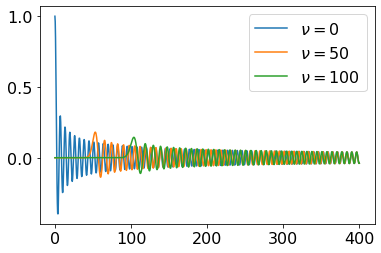

In [38]:
plt.figure()
for i in range(len(seed_nu)):
    plt.plot(x, seed_training[i], label=rf'$\nu = {seed_nu[i]}$')
plt.legend()

In [39]:
grb = GreedyReducedBasis(integration=integration, ts_dimension=1)

In [40]:
seed_nu

array([  0,  50, 100])

In [41]:
grb.build_seed_basis(ts=seed_training, ts_coords=seed_nu)

In [42]:
grb.basis

array([[ 0.58190184,  0.55885749,  0.49245617, ..., -0.01958921,
        -0.02289922, -0.02259244],
       [-0.00906898, -0.00870984, -0.00767497, ..., -0.03554766,
        -0.04165316, -0.04128214],
       [-0.00096901, -0.00093064, -0.00082006, ..., -0.04267922,
        -0.04920709, -0.0484455 ]])

In [43]:
new_nu = [25, 2, 79]
new_ts = np.array([BesselJ(nn, x) for nn in new_nu])

In [44]:
np.array(new_nu).shape

(3,)

In [45]:
# grb.greedy_sweep(new_ts, new_nu, greedy_tol=1.6)

In [46]:
grb.greedy_points

array([  0,  50, 100])

In [47]:
new_new_nu = np.random.uniform(0,100, size=100)
new_new_ts = np.array([BesselJ(nn, x) for nn in new_new_nu])

In [48]:
grb.greedy_sweep(new_new_ts, new_new_nu, greedy_tol=1e-12)

step = 0, error = 2.2588337970709356
step = 1, error = 1.7810975227362165
step = 2, error = 1.7182811102315425
step = 3, error = 1.651430231361102
step = 4, error = 1.6030320335452557
step = 5, error = 1.5575493757948438
step = 6, error = 1.5364524081425652
step = 7, error = 1.5110928481144061
step = 8, error = 1.4861727088144512
step = 9, error = 1.4701631468757732
step = 10, error = 1.449255995810759
step = 11, error = 1.4353297645907126
step = 12, error = 1.413635113901147
step = 13, error = 1.3957177086886297
step = 14, error = 1.3850053528603437
step = 15, error = 1.3610777707697952
step = 16, error = 1.3405428496443412
step = 17, error = 1.334418060401966
step = 18, error = 1.3269904236543624
step = 19, error = 1.3172965639645182
step = 20, error = 1.30037217635492
step = 21, error = 1.2789045452450973
step = 22, error = 1.2769300337904803
step = 23, error = 1.2754897661852962
step = 24, error = 1.2706563068263417
step = 25, error = 1.2694333046429003
step = 26, error = 1.2551193

In [49]:
grb.greedy_points

array([  0.        ,  50.        , 100.        ,   1.03087678,
         4.54965142,   8.09244897,  20.39097992,  16.80448459,
        33.12668293,  34.69729318,   6.22060467,   3.07607799,
        41.27905671,  51.63653114,  22.51518939,  45.54948279,
        62.51369282,  19.01145269,  66.54569276,  73.47858448,
        53.87112785,  77.80707504,  29.5833212 ,  82.06587424,
        89.12633057,  36.41236343,  68.5603657 ,  11.45180876,
        79.92457534,  93.76423442,  97.90925959,  13.69446838,
        25.25715426,  91.4883664 ,  75.99412918,  87.37929946,
        55.21566291,  47.10324333,  70.59174664,  56.88769009,
        83.88267421,  42.41923542,  37.82923703,  65.38679504,
        30.26448828,  96.98402208,  61.23024447,  25.69575664,
         1.63515365,  17.72367903,   7.41762406,  86.3255868 ,
         0.63682404,  99.06149424,  39.94407674,   4.05474177,
        93.18895693,  23.06607537,  48.7306285 ,   5.50315406,
        99.92492753,  69.48812369,  11.41513599,   3.27

In [50]:
?grb.compute_projection_coefficients_array

Signature: grb.compute_projection_coefficients_array(basis, ts)
Docstring:
loop over all vectors in the training set (ts)
and compute their projection coefficients by
computes their projection onto the basis

returns:
    alphas: numpy.ndarray
        alphas.shape = (ts.shape[0], basis.shape[0])
File:      ~/work/git/stk/ml/waveforms/surrogate/rom/<ipython-input-36-63b966c2e177>
Type:      method


In [51]:
alphas = grb.compute_projection_coefficients_array(grb.basis, new_new_ts)

In [52]:
alphas.shape

(100, 77)

In [53]:
grb.basis.shape

(77, 1001)

In [54]:
alphas[:,0]

array([ 1.02143700e-01,  5.16219591e-02, -3.11195175e-02,  1.59927378e-02,
        1.87350378e-02, -6.74915289e-02, -6.86681138e-03, -4.65077688e-02,
        3.35160786e-02, -4.64327113e-02, -7.77090524e-02,  5.86120219e-01,
        6.31732583e-01,  1.64842873e-02, -3.15053593e-02,  1.17812402e-01,
        1.34887968e-01, -1.24747165e-01, -1.04734517e-02,  2.63288881e-03,
       -6.90668186e-03,  2.37084313e-02, -1.77653384e-02, -1.49266994e-02,
       -3.14001138e-02,  1.84767686e-03, -6.99864356e-03,  8.86517897e-01,
       -4.83497549e-02, -1.45695745e-02, -5.64710147e-02, -4.72232340e-01,
        2.36002433e-02, -5.21727488e-01, -8.51525995e-02,  2.33154690e-03,
        8.52851743e-03,  1.90901448e-03, -2.23471868e-04,  3.62164472e-01,
       -1.83323913e-02,  2.56937161e-02,  1.25496870e-02,  1.01289328e-01,
        1.53082687e-02, -4.93071543e-02,  4.40903501e-03, -1.57401450e-02,
        1.50672227e-01, -2.62650771e-02, -1.63790934e-02,  1.69768677e-02,
       -1.54097971e-01, -

In [55]:
grb.greedy_points.shape

(77,)

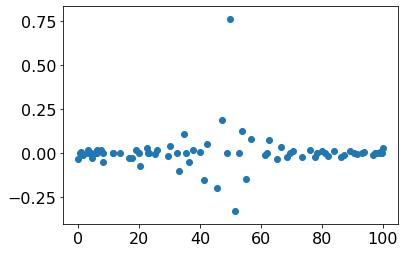

In [76]:
plt.figure()
plt.scatter(grb.greedy_points, alphas[2])

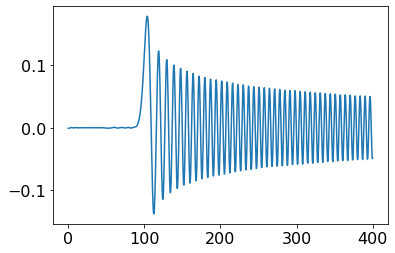

In [77]:
plt.figure()
plt.plot(x, grb.basis[2])

In [78]:
import rompy as rp

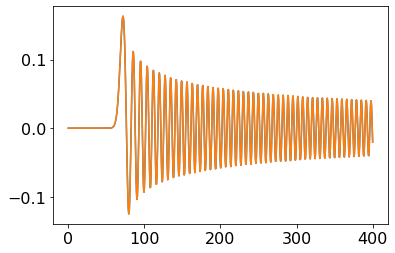

In [79]:
plt.figure()
plt.plot(x, grb.compute_representation(alphas[-20], grb.basis))
plt.plot(x, new_new_ts[-20])

In [80]:
eim = rp.EmpiricalInterpolant(grb.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 0)
(2, '\t', 132)
(3, '\t', 259)
(4, '\t', 5)
(5, '\t', 15)
(6, '\t', 24)
(7, '\t', 57)
(8, '\t', 48)
(9, '\t', 89)
(10, '\t', 125)
(11, '\t', 96)
(12, '\t', 20)
(13, '\t', 106)
(14, '\t', 251)
(15, '\t', 192)
(16, '\t', 117)
(17, '\t', 167)
(18, '\t', 63)
(19, '\t', 176)
(20, '\t', 212)
(21, '\t', 217)
(22, '\t', 202)
(23, '\t', 79)
(24, '\t', 235)
(25, '\t', 226)
(26, '\t', 162)
(27, '\t', 185)
(28, '\t', 32)
(29, '\t', 281)
(30, '\t', 242)
(31, '\t', 315)
(32, '\t', 41)
(33, '\t', 72)
(34, '\t', 363)
(35, '\t', 514)
(36, '\t', 299)
(37, '\t', 368)
(38, '\t', 420)
(39, '\t', 265)
(40, '\t', 442)
(41, '\t', 711)
(42, '\t', 142)
(43, '\t', 996)
(44, '\t', 601)
(45, '\t', 147)
(46, '\t', 781)
(47, '\t', 154)
(48, '\t', 328)
(49, '\t', 111)
(50, '\t', 913)
(51, '\t', 9)
(52, '\t', 501)
(53, '\t', 1)
(54, '\t', 1000)
(55, '\t', 294)
(56, '\t', 84)
(57, '\t', 597)
(58, '\t', 901)
(59, '\t', 197)
(60, '\t', 2)
(61, '\t', 275)
(62, '\t', 801)
(63, '\t', 36

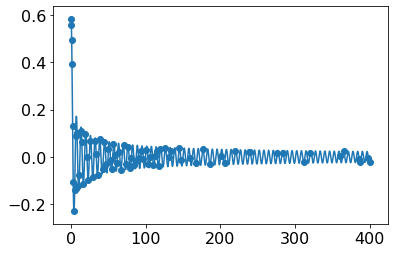

In [81]:
plt.figure()
plt.plot(x, grb.basis[0])
plt.scatter(x[eim.indices], grb.basis[0][eim.indices])

In [84]:
eim.make_data(new_new_ts)

In [85]:
eim.data

array([[-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 8.04795045e-02,  1.71656510e-01,  1.79901596e-01, ...,
        -1.29801144e-02,  1.68996053e-04, -1.08725855e-01],
       [-7.56069030e-02, -2.91462635e-02,  7.49829016e-02, ...,
        -1.98648396e-02, -6.67834028e-02, -6.29926045e-02],
       ...,
       [ 6.75132757e-02,  1.69115129e-01,  1.14654990e-01, ...,
        -1.24638301e-01,  7.09821109e-04,  5.83969450e-02],
       [-1.53333084e-02,  3.64924395e-02, -4.88621226e-02, ...,
        -5.63585478e-03,  5.31146125e-02,  3.84198980e-02],
       [ 3.39051606e-08,  8.41387971e-29,  1.70898469e-27, ...,
         4.56443919e-16,  6.15745274e-44,  2.32906369e-01]])

In [87]:
eim.data.shape

(77, 100)

In [88]:
grb.greedy_points.shape

(77,)

In [92]:
eim.data.shape

(77, 100)

In [98]:
eim.data.shape

(77, 100)

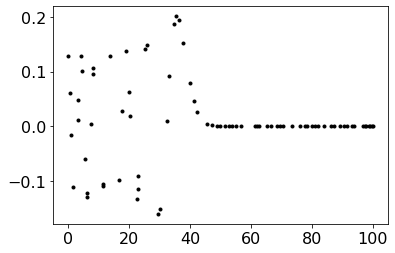

In [105]:
plt.plot(grb.greedy_points, BesselJ(grb.greedy_points, x[eim.indices[10]]), 'k.')

In [ ]:
# Spline interpolant of the data at the 11th empirical node
fit = rp.UnivariateFits(nu, eim.data[10], fit='spline', s=0, deg=5)

plt.plot(nu, BesselJ(nu, x[eim.indices[10]]), 'k.')
plt.plot(nu, fit(nu), 'r-')
plt.xlabel('$\\nu$');

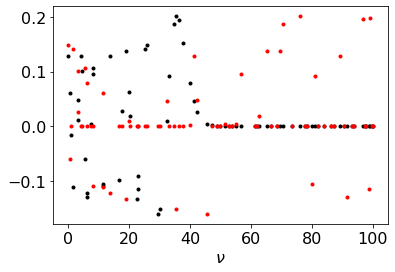

In [107]:
# Spline interpolant of the data at the 11th empirical node
fit = rp.UnivariateFits(grb.greedy_points, eim.data[10], fit='spline', s=0, deg=5)

plt.plot(grb.greedy_points, BesselJ(grb.greedy_points, x[eim.indices[10]]), 'k.')
plt.plot(grb.greedy_points, fit(grb.greedy_points), 'r-')
plt.xlabel('$\\nu$');

In [65]:
newest_nu = grb.greedy_points
newest_ts = np.array([BesselJ(nn, x) for nn in newest_nu])

In [66]:
u, s, vh = np.linalg.svd(newest_ts, full_matrices=True)

In [69]:
vh.shape

(1001, 1001)

In [70]:
u.shape

(77, 77)

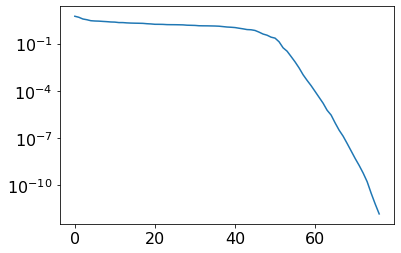

In [71]:
plt.figure()
plt.plot(range(len(s)), s)
plt.yscale('log')

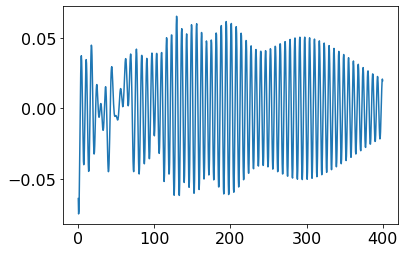

In [72]:
plt.figure()
plt.plot(x, vh[4])

In [73]:
eim = rp.EmpiricalInterpolant(vh[:72], verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 29)
(2, '\t', 2)
(3, '\t', 160)
(4, '\t', 267)
(5, '\t', 520)
(6, '\t', 24)
(7, '\t', 56)
(8, '\t', 600)
(9, '\t', 70)
(10, '\t', 273)
(11, '\t', 256)
(12, '\t', 16)
(13, '\t', 419)
(14, '\t', 466)
(15, '\t', 154)
(16, '\t', 354)
(17, '\t', 8)
(18, '\t', 200)
(19, '\t', 184)
(20, '\t', 95)
(21, '\t', 50)
(22, '\t', 247)
(23, '\t', 128)
(24, '\t', 112)
(25, '\t', 241)
(26, '\t', 64)
(27, '\t', 206)
(28, '\t', 300)
(29, '\t', 229)
(30, '\t', 167)
(31, '\t', 84)
(32, '\t', 305)
(33, '\t', 35)
(34, '\t', 147)
(35, '\t', 213)
(36, '\t', 139)
(37, '\t', 388)
(38, '\t', 105)
(39, '\t', 222)
(40, '\t', 43)
(41, '\t', 192)
(42, '\t', 784)
(43, '\t', 121)
(44, '\t', 330)
(45, '\t', 637)
(46, '\t', 924)
(47, '\t', 0)
(48, '\t', 176)
(49, '\t', 78)
(50, '\t', 235)
(51, '\t', 1000)
(52, '\t', 756)
(53, '\t', 100)
(54, '\t', 5)
(55, '\t', 367)
(56, '\t', 996)
(57, '\t', 904)
(58, '\t', 1)
(59, '\t', 516)
(60, '\t', 134)
(61, '\t', 279)
(62, '\t', 12)
(63, '\t', 47

In [74]:
vh[0][eim.indices]

array([-1.05463906e-01,  2.12258930e-02,  8.53855843e-03, -4.89330275e-02,
       -3.38785882e-02,  8.79080488e-03,  4.63114526e-02, -1.92736841e-02,
        6.85888686e-02,  4.01508678e-02,  2.26798786e-02, -2.38001760e-02,
        2.16261035e-02,  2.47011133e-02, -3.77207436e-02,  4.42473469e-02,
        1.28913736e-02, -1.05570186e-02, -1.00646976e-02, -5.09839103e-02,
        2.60965832e-03,  9.24782789e-05, -6.59608992e-03, -2.56879072e-02,
        3.60731489e-02, -3.13955410e-02, -3.09320913e-02, -3.57678321e-02,
        3.97843189e-02,  1.56208514e-02,  5.18184117e-02,  4.36496080e-02,
        5.18765062e-02,  4.50316012e-02,  4.40095276e-02, -3.93761436e-02,
        1.40432083e-02,  1.25505394e-02, -2.60880889e-02, -3.50752576e-02,
        9.89029052e-03, -1.98597306e-02, -1.69528112e-03, -4.67966909e-02,
        3.58330803e-02,  9.55766930e-04, -2.46860156e-02,  7.87142101e-03,
       -7.82950856e-02, -5.18384595e-02,  2.25302405e-02, -2.95548878e-02,
        3.92837404e-02,  

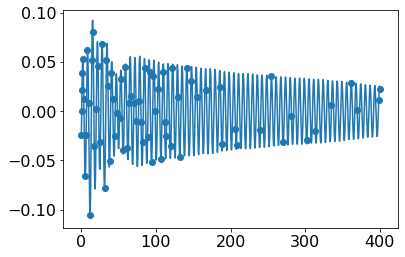

In [75]:
plt.figure()
plt.plot(x, vh[0])
plt.scatter(x[eim.indices], vh[0][eim.indices])
